In [1]:
#Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib import pyplot
import time
import os
import torch
import torchvision
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder

In [2]:
!unzip "/content/drive/MyDrive/Dataset_3.zip"

Archive:  /content/drive/MyDrive/Dataset_3.zip
   creating: trashify-image-dataset/
  inflating: __MACOSX/._trashify-image-dataset  
   creating: trashify-image-dataset/paper/
  inflating: __MACOSX/trashify-image-dataset/._paper  
   creating: trashify-image-dataset/metal/
  inflating: __MACOSX/trashify-image-dataset/._metal  
   creating: trashify-image-dataset/plastic/
  inflating: __MACOSX/trashify-image-dataset/._plastic  
  inflating: trashify-image-dataset/paper/IMG_20200416_215618.jpg  
  inflating: __MACOSX/trashify-image-dataset/paper/._IMG_20200416_215618.jpg  
  inflating: trashify-image-dataset/paper/IMG_20200416_215142.jpg  
  inflating: __MACOSX/trashify-image-dataset/paper/._IMG_20200416_215142.jpg  
  inflating: trashify-image-dataset/paper/20200416_213410.jpg  
  inflating: __MACOSX/trashify-image-dataset/paper/._20200416_213410.jpg  
  inflating: trashify-image-dataset/paper/IMG_20200416_215234.jpg  
  inflating: __MACOSX/trashify-image-dataset/paper/._IMG_20200416_21

In [3]:
   data_dir = "trashify-image-dataset"

In [4]:
transform = transforms.Compose([
      transforms.Resize((227,227)),
      transforms.ColorJitter(brightness=0.5, contrast=0.5, saturation=0, hue=0),
      transforms.RandomHorizontalFlip(0.3),
      transforms.RandomVerticalFlip(0.2),
      transforms.ToTensor(),
      transforms.Normalize(mean=[.5], std=[.5]),
      ])

In [5]:
dataset = ImageFolder(data_dir, transform = transform)

Label: metal (Class No: 0)


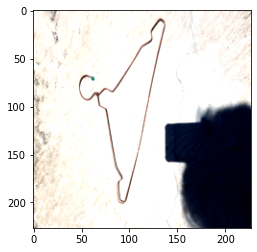

In [6]:
import matplotlib.pyplot as plt
%matplotlib inline

def show_sample(img, label):
    print("Label:", dataset.classes[label], "(Class No: "+ str(label) + ")")
    plt.imshow(img.permute(1, 2, 0))

img, label = dataset[10]
show_sample(img, label)

In [7]:
random_seed = 42
torch.manual_seed(random_seed)

In [8]:
train_ds, val_ds, test_ds = random_split(dataset, [220, 36, 100])
len(train_ds), len(val_ds), len(test_ds)

(220, 36, 100)

In [9]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32
num_classes = 7

In [10]:
train_dl = DataLoader(train_ds, batch_size, shuffle = True, num_workers = 4, pin_memory = True)
val_dl = DataLoader(val_ds, batch_size*2, num_workers = 4, pin_memory = True)
test_dl = DataLoader(test_ds, batch_size*2, num_workers = 4, pin_memory = True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [11]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([])
        ax.set_yticks([])
        ax.imshow(make_grid(images, nrow = 16).permute(1, 2, 0))
        break

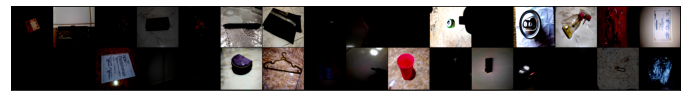

In [12]:
show_batch(train_dl)

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassificationBase(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch {}: train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch+1, result['train_loss'], result['val_loss'], result['val_acc']))

In [14]:
class AlexNet(nn.Module):
    def __init__(self, num_classes=10):
        super(AlexNet, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=0),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer2 = nn.Sequential(
            nn.Conv2d(96, 256, kernel_size=5, stride=1, padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.layer3 = nn.Sequential(
            nn.Conv2d(256, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer4 = nn.Sequential(
            nn.Conv2d(384, 384, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU())
        self.layer5 = nn.Sequential(
            nn.Conv2d(384, 256, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size = 3, stride = 2))
        self.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(9216, 4096),
            nn.ReLU())
        self.fc1 = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU())
        self.fc2= nn.Sequential(
            nn.Linear(4096, num_classes))
        
    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.layer5(out)
        out = out.reshape(out.size(0), -1)
        out = self.fc(out)
        out = self.fc1(out)
        out = self.fc2(out)
        return out

In [16]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
device = get_default_device()
device

device(type='cpu')

In [18]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
model = AlexNet(7).to(device)
learning_rate = 0.005

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, weight_decay = 0.005, momentum = 0.9)

In [19]:
total_step = len(train_dl)
num_epochs = 5
history = []

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_dl):  
        # Move tensors to the configured device
        images = images.to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    print ('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}' 
                   .format(epoch+1, num_epochs, i+1, total_step, loss.item()))
            
    # Validation
    with torch.no_grad():
        correct = 0
        total = 0
        for images, labels in val_dl:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            del images, labels, outputs
        history.append(100 * correct / total)
        print('Accuracy of the network on the {} validation images: {} %'.format(5000, 100 * correct / total))

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Epoch [1/5], Step [7/7], Loss: 1.0886
Accuracy of the network on the 5000 validation images: 36.111111111111114 %
Epoch [2/5], Step [7/7], Loss: 1.0625
Accuracy of the network on the 5000 validation images: 38.888888888888886 %
Epoch [3/5], Step [7/7], Loss: 1.5159
Accuracy of the network on the 5000 validation images: 41.666666666666664 %
Epoch [4/5], Step [7/7], Loss: 1.1841
Accuracy of the network on the 5000 validation images: 52.77777777777778 %
Epoch [5/5], Step [7/7], Loss: 0.9532
Accuracy of the network on the 5000 validation images: 38.888888888888886 %


In [21]:
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_dl:
        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        del images, labels, outputs

    print('Accuracy of the network on the {} test images: {} %'.format(10000, 100 * correct / total))   

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:566: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


Accuracy of the network on the 10000 test images: 35.0 %


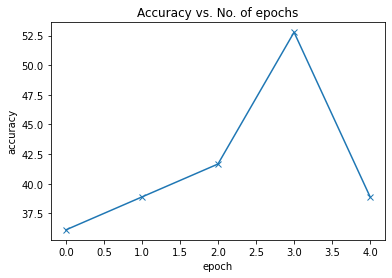

In [20]:
def plot_accuracies(history):
    accuracies = [x for x in history]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(history)